In [1]:
import torch
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import uuid
import sys

In [2]:
sys.path.append("../")
import TorchData

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
X=88
Y=128
T_OFFSET=100
NUM_DATA=5096
SIGNAL_COUNT_MIN=300
SIGNAL_COUNT_MAX=301
SIGNAL_SELECT_MODE="retain"
NOISE_DENSITY=0.01
NOISE_MAGNITUDE=1.0
BLUR_LEVEL=0
DISPERSION_LEVEL=0
MODE="normal"

BATCH_SIZE=512
EPOCH=100
MULTI_GPU=True

model_name = "ConvolutionalAutoencoder"

In [59]:
# set random seed for reproducibility
import numpy as np
np.random.seed(0)

In [5]:
train_dataset = TorchData.TORCHData(x=X, y=Y, num_data=NUM_DATA,
                                    signal_count=(SIGNAL_COUNT_MIN, SIGNAL_COUNT_MAX), signal_select_mode=SIGNAL_SELECT_MODE,
                                    noise_density=NOISE_DENSITY, t_offset=T_OFFSET,
                                    blur_level=BLUR_LEVEL, dispersion_level=DISPERSION_LEVEL, mode=MODE)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

In [60]:
test_dataset = TorchData.TORCHData(x=X, y=Y, num_data=1024,
                                   signal_count=(SIGNAL_COUNT_MIN, SIGNAL_COUNT_MAX), signal_select_mode=SIGNAL_SELECT_MODE,
                                   noise_density=NOISE_DENSITY, t_offset=T_OFFSET,
                                   blur_level=BLUR_LEVEL, dispersion_level=DISPERSION_LEVEL, mode=MODE)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

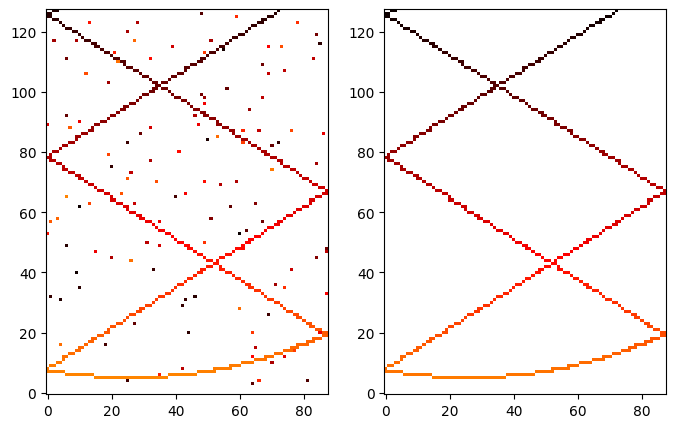

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(train_dataset.sn_time[0], aspect="auto", cmap="hot_r", origin="lower")
ax[1].imshow(train_dataset.signal_time[0], aspect="auto", cmap="hot_r", origin="lower")

In [8]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),  # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1), # Output: (64, 15, 12)
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            # torch.nn.Flatten(1),
            # torch.nn.Linear(64*114*84, 128),
            # torch.nn.ReLU(),
        )
        
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(128, 64*114*84),
            # torch.nn.ReLU(),
            # torch.nn.Unflatten(1, (64, 114, 84)),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1), # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1), # Output: (1, 120, 90)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = ConvolutionAutoencoder()
if MULTI_GPU:
    model = torch.nn.DataParallel(model)
model = model.to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
summary(model, input_size=(16, 1, Y, X))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [16, 1, 128, 88]          --
├─ConvolutionAutoencoder: 1-1            [16, 1, 128, 88]          --
│    └─Sequential: 2-1                   [16, 8, 122, 82]          --
│    │    └─Conv2d: 3-1                  [16, 64, 126, 86]         640
│    │    └─BatchNorm2d: 3-2             [16, 64, 126, 86]         128
│    │    └─ReLU: 3-3                    [16, 64, 126, 86]         --
│    │    └─Conv2d: 3-4                  [16, 16, 124, 84]         9,232
│    │    └─BatchNorm2d: 3-5             [16, 16, 124, 84]         32
│    │    └─ReLU: 3-6                    [16, 16, 124, 84]         --
│    │    └─Conv2d: 3-7                  [16, 8, 122, 82]          1,160
│    │    └─BatchNorm2d: 3-8             [16, 8, 122, 82]          16
│    │    └─ReLU: 3-9                    [16, 8, 122, 82]          --
│    └─Sequential: 2-2                   [16, 1, 128, 88]          --
│    │ 

In [11]:
scalar = torch.amp.GradScaler()

for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()

        with torch.amp.autocast(device):
            outputs = model(x.to(device))
            loss = loss_function(outputs, y.to(device))

        scalar.scale(loss).backward()
        scalar.step(optimiser)
        scalar.update()

100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


In [12]:
# uid = uuid.uuid4()
# file_name = f"{model_name}_{uid}.pth"
# torch.save(model.state_dict(), f"{file_name}")

In [61]:
### Using pretrained weights
model.load_state_dict(torch.load(f"../ModelWeights/HDT_vs_CAE/ConvolutionAutoencoder_300.pth", map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [62]:
model.eval()
with torch.no_grad():
    pred = model(test_dataset.input_data.to(device)).to("cpu")

pred = test_dataset.input_data * (pred > 1)
test_dataset.predict_data = pred

(<Figure size 1401x400 with 4 Axes>,
 array([[<Axes: title={'center': 'Input Data'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 'Target Data'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 'Predict Data'}, xlabel='X', ylabel='Y'>]],
       dtype=object))

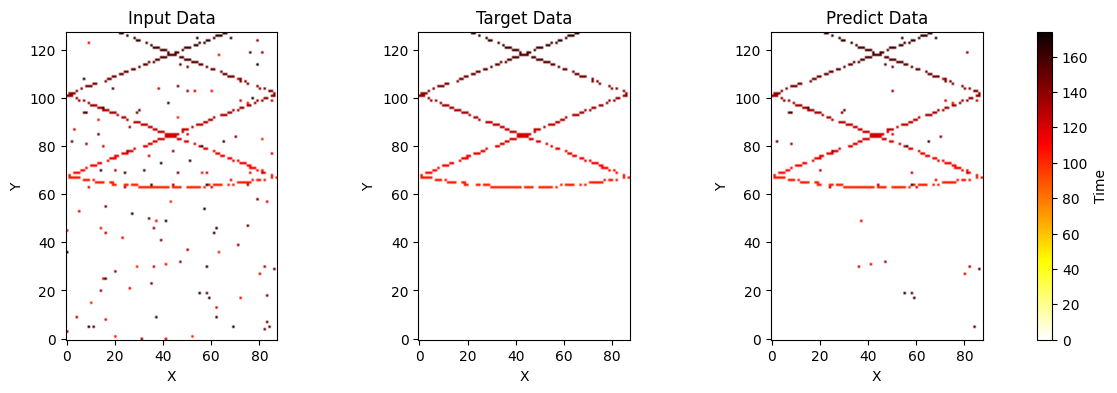

In [63]:
TorchData.plot2d_f(test_dataset, ["input_data", "target_data", "predict_data"], index=0, cmap="hot_r")

(<Figure size 1500x600 with 4 Axes>,
 array([[<Axes3D: title={'center': 'Input Data'}, xlabel='X', ylabel='Y', zlabel='Time'>,
         <Axes3D: title={'center': 'Target Data'}, xlabel='X', ylabel='Y', zlabel='Time'>,
         <Axes3D: title={'center': 'Predict Data'}, xlabel='X', ylabel='Y', zlabel='Time'>]],
       dtype=object))

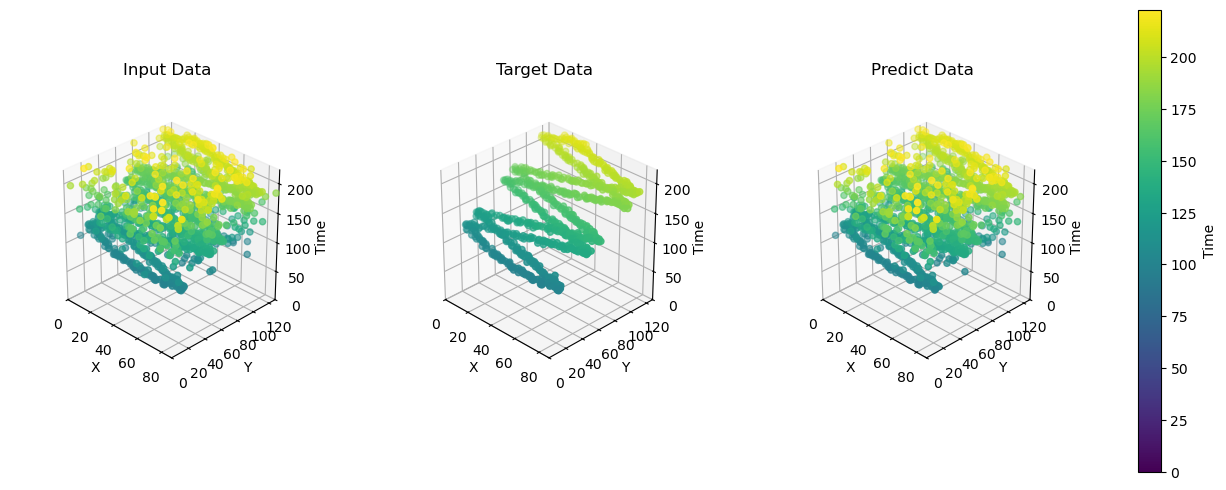

In [16]:
TorchData.visual.plot3d_f(test_dataset, ["input_data", "target_data", "predict_data"], index=0)

In [57]:
TorchData.get_metrics(test_dataset.target_data, test_dataset.predict_data, test_dataset.input_data)

torch.Size([1024, 1, 128, 88])


{'Signal Retention Rate': 0.985234375,
 'Signal Retention Standard Deviation:': 0.026997249573469162,
 'Noise Removal Rate': 0.046901609147464635,
 'Noise Removal Standard Deviation:': 0.019836004823446274,
 'MSE': 211.47518920898438,
 'PSNR': 23.90610122680664,
 'SSIM': tensor(0.6451),
 'ROC AUC': 0.9870059569516908,
 'F1': 0.3142615066410825,
 'F1 Standard Deviation:': 0.021916672587394714}